<a href="https://colab.research.google.com/github/TejeshTawania/EEG_Signal_Analysis/blob/main/Team12_BT421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**


In [ ]:
#@title {vertical-output : true}
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
!pip install pyriemann
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from scipy.integrate import simpson
from scipy.signal import welch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.7/127.7 kB 2.6 MB/s eta 0:00:00


# **Data Import and Initital Analysis**

In [ ]:
mat_data = sio.loadmat('/content/BT524_ProjectData_CWL.mat')

print("Variables in the .mat file:")
for key in mat_data:
  if not key.startswith('__'):
    print(key)

eeg_df = pd.DataFrame(mat_data['eeg'][0])
print(f'\nEEG Data {eeg_df.shape}:')
display(eeg_df.iloc[:5, :6])

Variables in the .mat file:
eeg
workload

EEG Data (500, 447):


,0,1,2,3,4,5
0,-3.014101,-1.411211,5.187558,-4.186014,-2.430458,-5.304288
1,-2.980668,-3.779438,5.272625,-6.335131,-3.811836,-6.208094
2,-3.135355,-6.296685,4.896626,-8.146572,-5.881743,-6.712073
3,-3.599880,-7.303020,3.011342,-8.386505,-7.065070,-6.281625
4,-4.130581,-6.743069,-0.277344,-7.788205,-6.557210,-5.401787


In [ ]:
sampling_frequency = 250 # Hz
sampling_time = 1/sampling_frequency # sec

Below code is used to check if flattening of workload key is done correctly and also ensure no bias for a particular workload level i.e. all 3 workloads have similar number of trials:

In [ ]:
workload = mat_data['workload'].flatten().tolist()

def check_wl():
  for i in range(447):
    if mat_data['workload'][i][0] != workload[i]:
      print('error')
      return

  c0,c1,c2 = 0,0,0
  for j in range(447):
    if workload[j] == 0:
      c0+=1
    elif workload[j] == 1:
      c1+=1
    elif workload[j] == 2:
      c2+=1
  print(c0, c1, c2)

check_wl()

149 149 149


**Descriptive Statistics**

In [ ]:
#@title {vertical-output : true}
labels = sorted(np.unique(workload))
stats_data = []

for label in labels:

    idx = [i for i, w in enumerate(workload) if w == label] # index of corresponding label
    subset_df = eeg_df.iloc[:, idx] # columns from eeg_df corresponding to the current label

    mean_val = np.mean(subset_df.values)
    variance_val = np.var(subset_df.values)
    skewness_val = skew(subset_df.values.flatten())
    kurtosis_val = kurtosis(subset_df.values.flatten())

    stats_data.append({
        'Workload': label,
        'Mean': mean_val,
        'Variance': variance_val,
        'Skewness': skewness_val,
        'Kurtosis': kurtosis_val
    })

stats_df = pd.DataFrame(stats_data)
print("Descriptive Statistics per Workload Label:")
display(stats_df)

Descriptive Statistics per Workload Label:


,Workload,Mean,Variance,Skewness,Kurtosis
0,0,-0.164473,62.419216,0.357225,1.984656
1,1,-0.322967,105.060646,1.241996,10.464412
2,2,-0.282717,122.562111,0.790310,6.233769


# **Plots of All Trials**

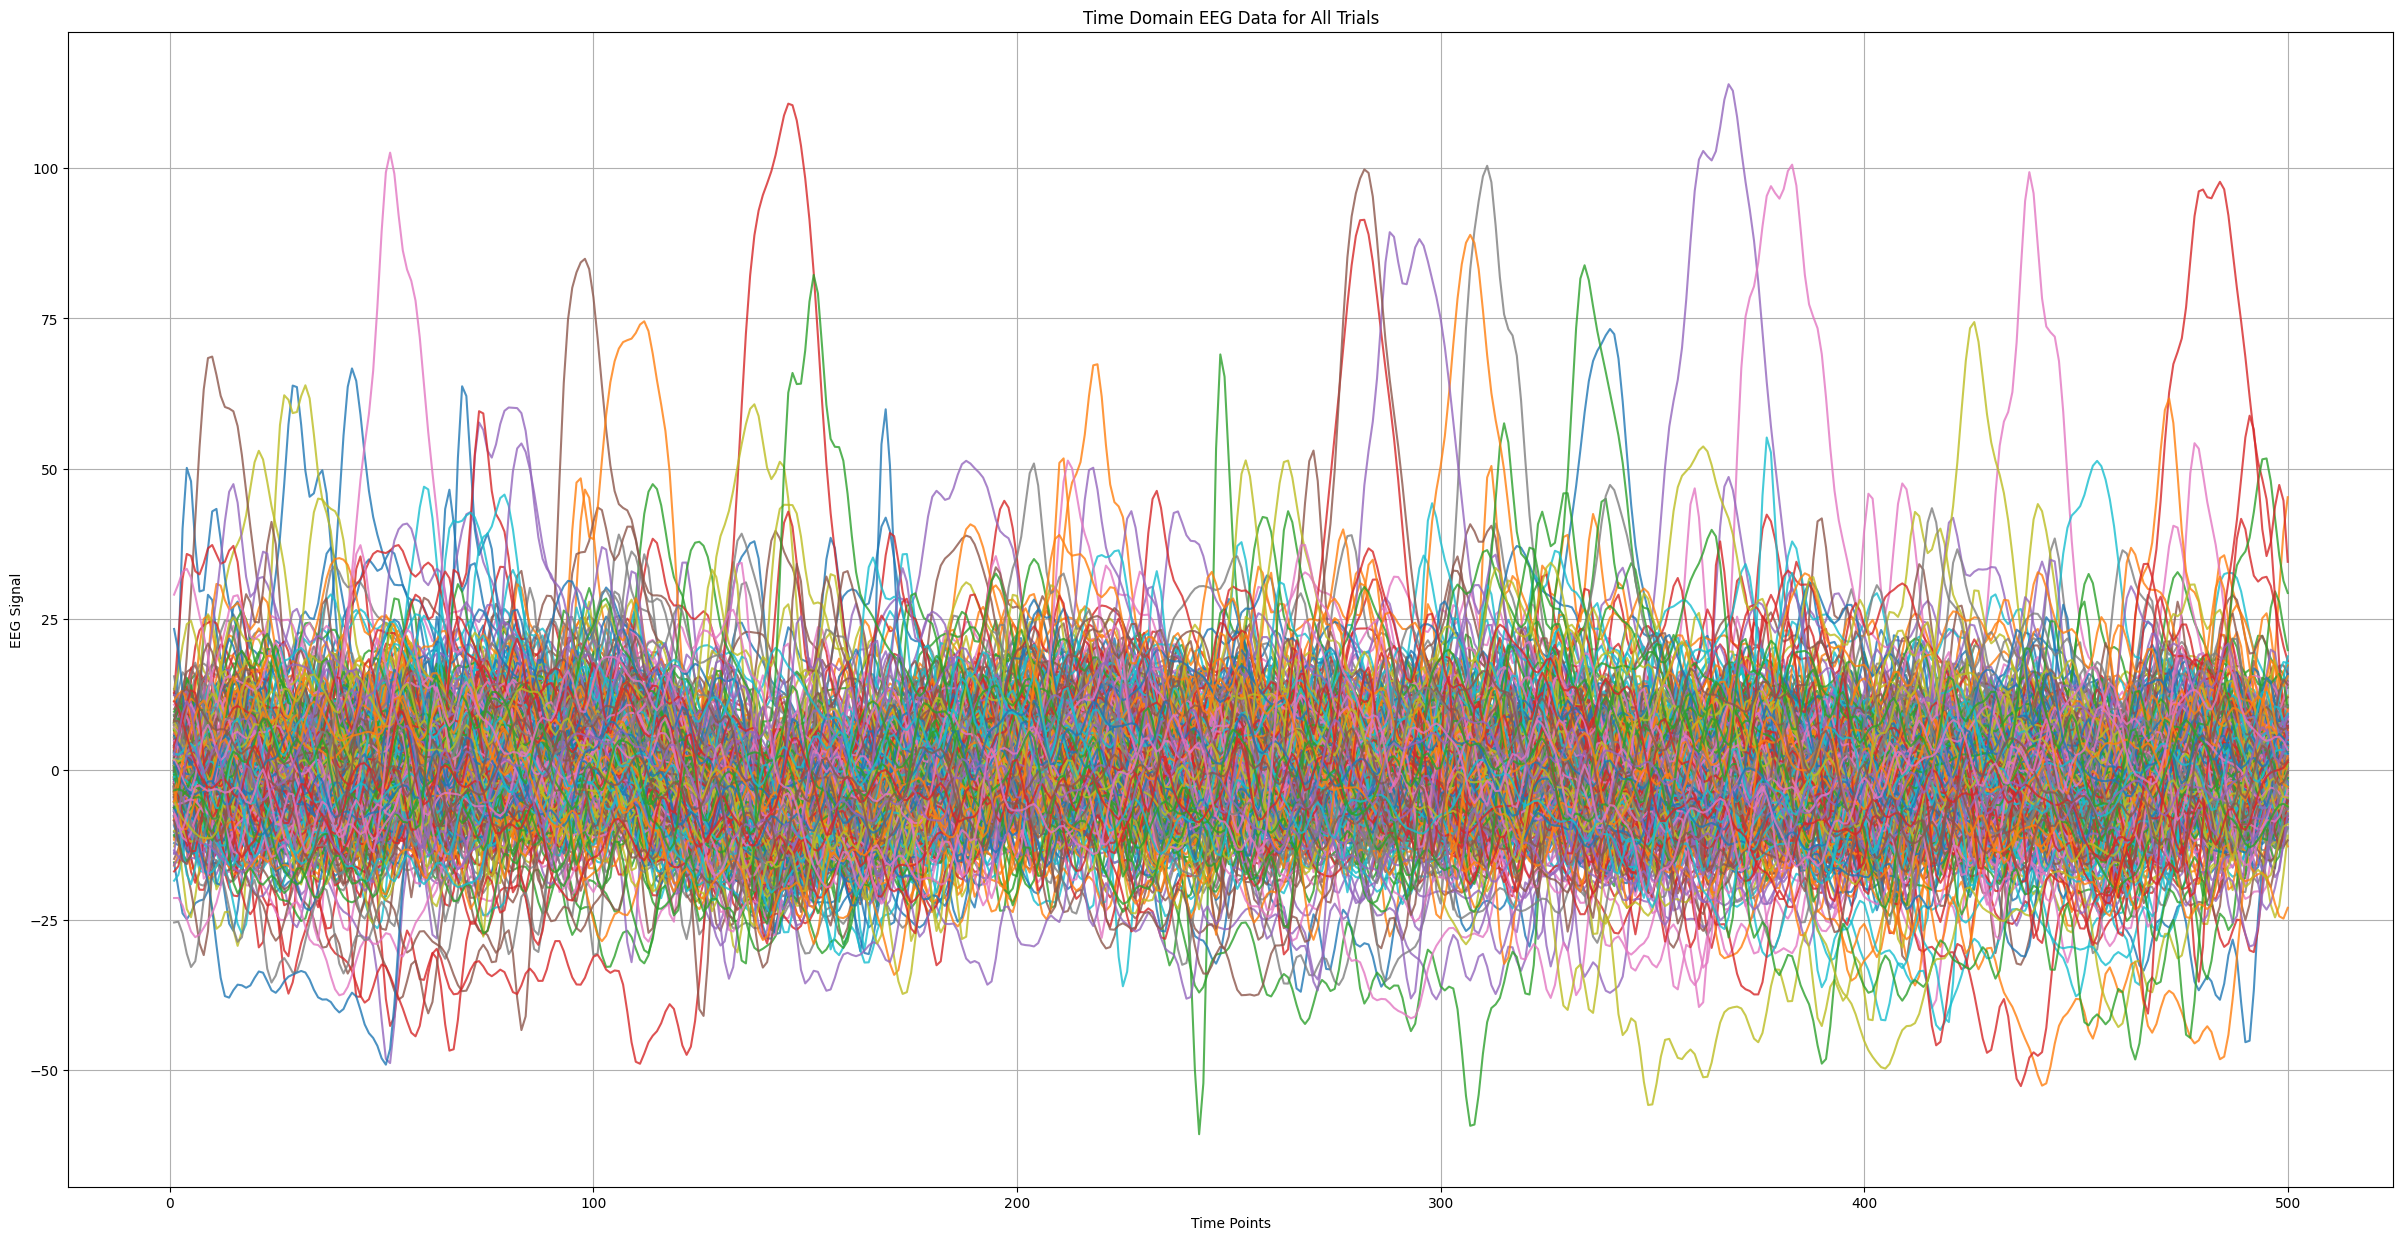

In [ ]:
time = np.arange(1, eeg_df.shape[0]+1)

plt.figure(figsize=(30,15))
for i in range(eeg_df.shape[1]):
  plt.plot(time , eeg_df[i], alpha = 0.8)
plt.xlabel('Time Points')
plt.ylabel('EEG Signal')
plt.title('Time Domain EEG Data for All Trials')
plt.grid()
# plt.savefig("All time domain.png")
plt.show()

Fast Fourier Transform was used to convert time domain values to frequency domain values. Since sampling frequency is 250 Hz, the frequency domain graph spans from -125 to +125 Hz. We have shown only positive side of the plot, and limited it to 0 to 50 Hz for better visualization.

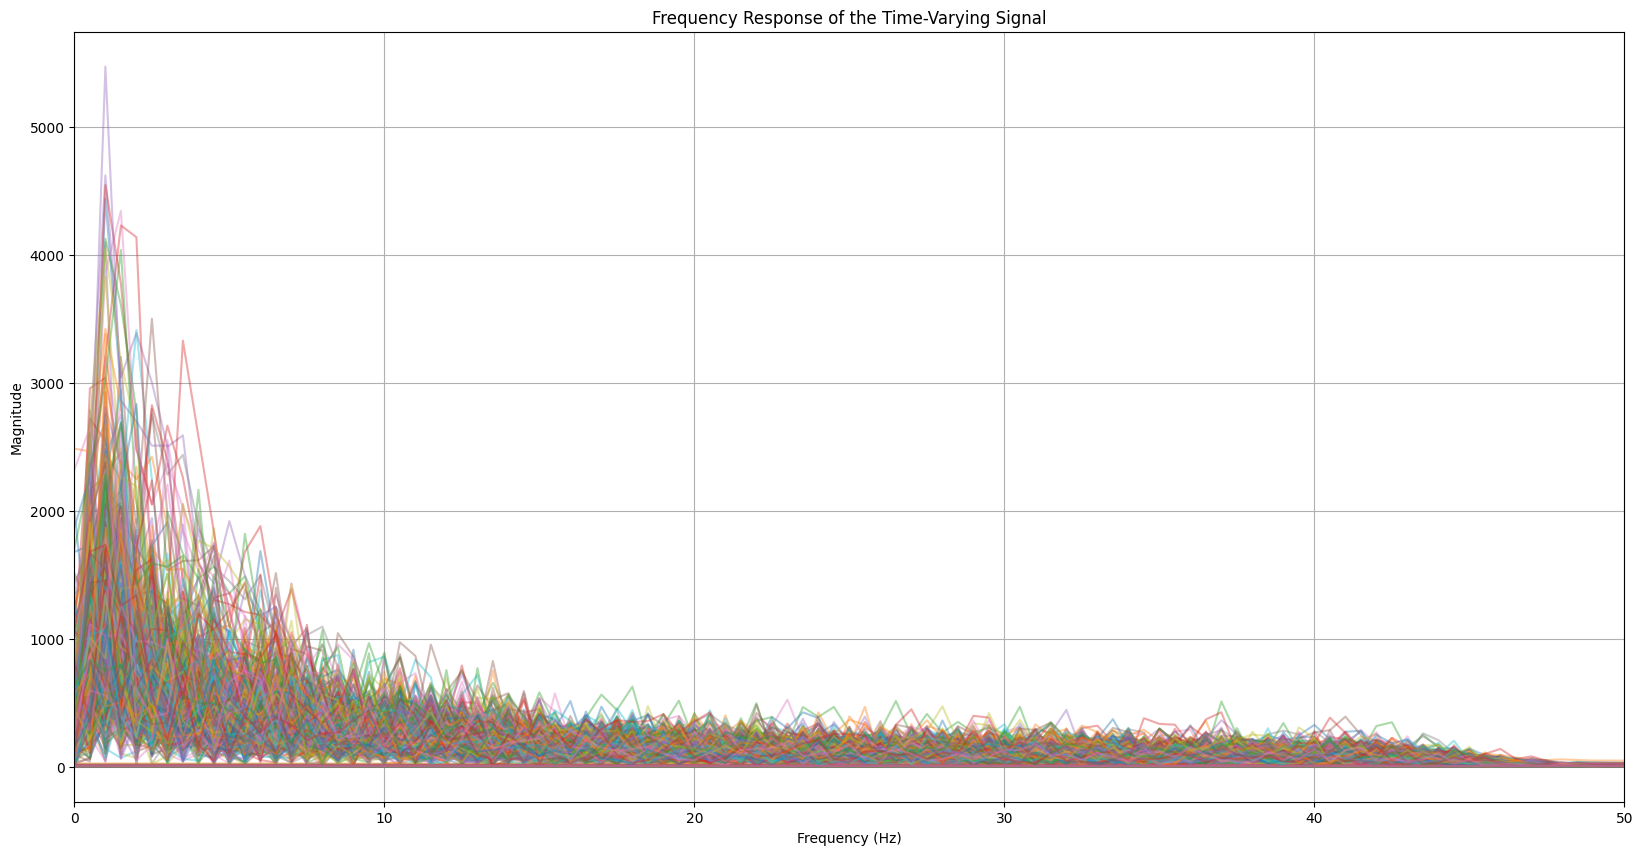

In [ ]:
xf = fftfreq(eeg_df.shape[0], sampling_time) # frequencies corresponding to waves

plt.figure(figsize=(20,10))
for i in range(eeg_df.shape[1]):
  yf = fft(eeg_df[i]) # Fast Fourier Transform (FFT)
  magnitude = np.abs(yf) # FFT magnitude
  plt.plot(xf, magnitude, alpha = 0.4)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Response of the Time-Varying Signal')
plt.grid(True)
plt.xlim(0, 50)
# plt.savefig("All freq domain.png")
plt.show()

# **Workload Specific Plots**


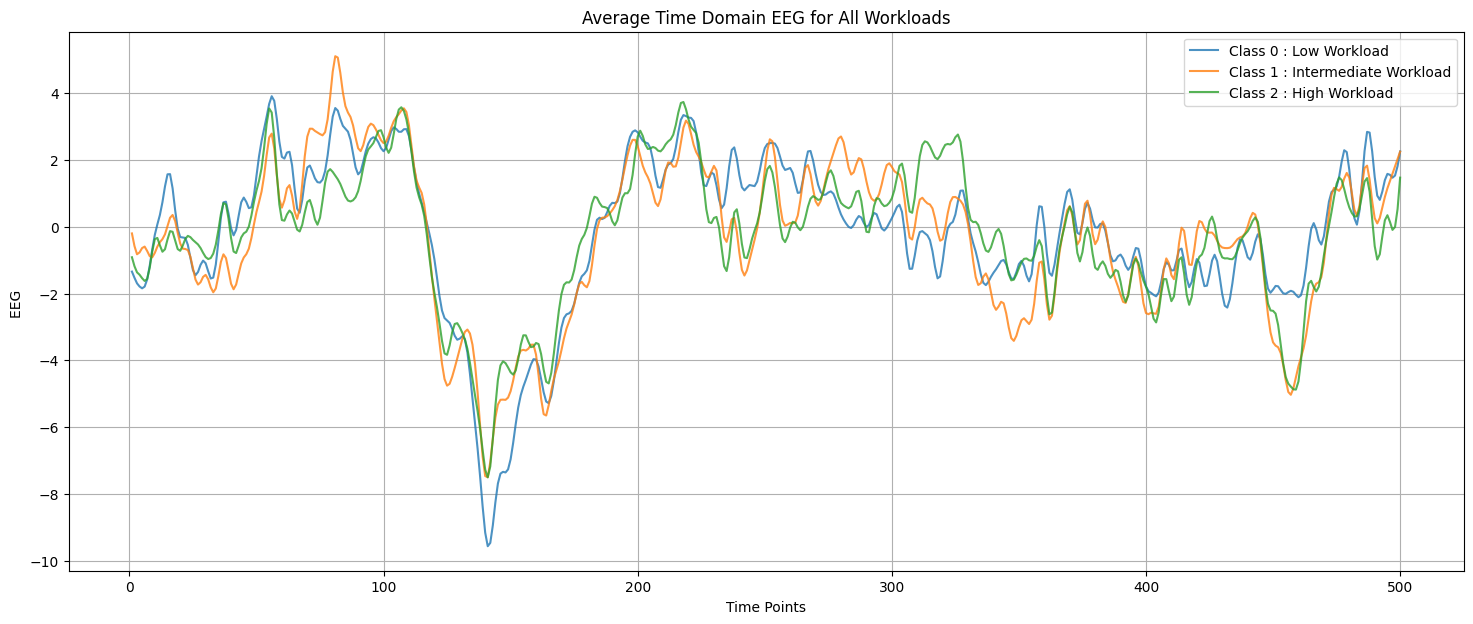

In [ ]:
labels = sorted(np.unique(workload))
time = np.arange(1, eeg_df.shape[0]+1)

custom_labels = {0: 'Class 0 : Low Workload',
                 1: 'Class 1 : Intermediate Workload',
                 2: 'Class 2 : High Workload'}

plt.figure(figsize=(18, 7))
for label in labels:
    idx = [i for i, w in enumerate(workload) if w == label]
    subset_df = eeg_df.iloc[:, idx]

    mean_per_label = subset_df.mean(axis=1) # mean signal across the selected trials

    plt.plot(time, mean_per_label, label=custom_labels[label], alpha = 0.8)

plt.title(f'Average Time Domain EEG for All Workloads')
plt.xlabel('Time Points')
plt.ylabel('EEG ')
plt.legend()
plt.grid(True)
# plt.savefig("Mean time domain.png")
plt.show()

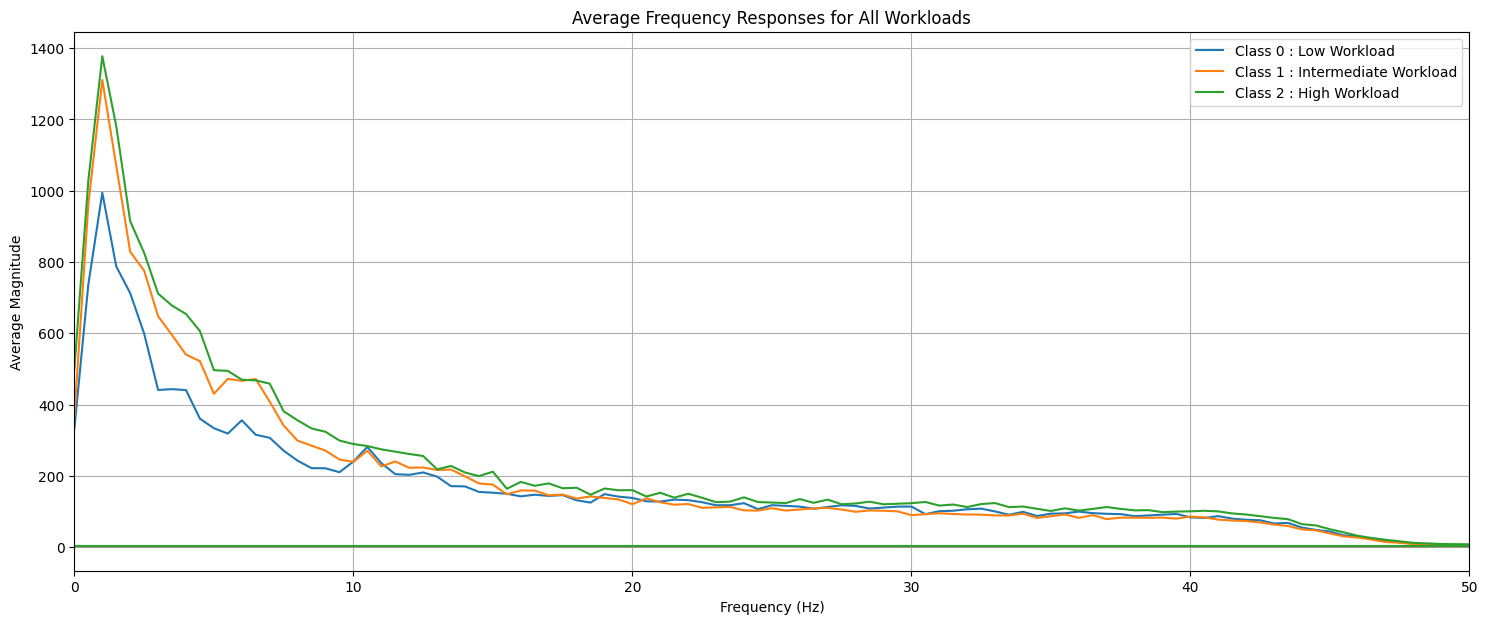

In [ ]:
xf = fftfreq(eeg_df.shape[0], sampling_time)
fft_magnitudes_list = []

for i in range(eeg_df.shape[1]):
    yf = fft(eeg_df[i]) # Fast Fourier Transform (FFT)
    magnitude = np.abs(yf) # FFT magnitude
    fft_magnitudes_list.append(magnitude)

fft_magnitudes_df = pd.DataFrame(fft_magnitudes_list).T

# Group and average FFT magnitudes by workload and plot

plt.figure(figsize=(18, 7))
for label in labels:
    idx = [i for i, w in enumerate(workload) if w == label]
    subset_fft_magnitudes_df = fft_magnitudes_df.iloc[:, idx]

    average_magnitude = subset_fft_magnitudes_df.mean(axis=1)  # mean FFT magnitude across the selected trials
    plt.plot(xf, average_magnitude, label=custom_labels[label])

plt.title(f'Average Frequency Responses for All Workloads')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Magnitude')
plt.xlim(0,50)
# plt.xlim(10, 50)
# plt.ylim(0, 200)
plt.legend()
plt.grid(True)
# plt.savefig("Mean Freq domain.png")
plt.show()

# **Classification Analysis**

In [ ]:
#@title {vertical-output : true}
test_index = pd.read_csv('/content/testIndices.csv', header=None)
print(f'\nTest Indices {test_index.shape}:')
display(test_index.iloc[:8,:])


Test Indices (89, 3):


,0,1,2
0,200,118,330
1,249,227,155
2,3,127,378
3,141,421,299
4,5,330,171
5,447,91,67
6,359,432,412
7,344,194,24


In [ ]:
def bandpass_filter(eeg_df, low_cut, high_cut, fs=250, order=4):
    nyquist = fs / 2
    normal_low = low_cut / nyquist
    normal_high = high_cut / nyquist
    b, a = butter(order, [normal_low, normal_high], btype='band', analog=False)
    filtered = []
    for i in range(eeg_df.shape[1]):
        filtered_signal = filtfilt(b, a, eeg_df[i].values)
        filtered.append(filtered_signal)
    eeg_filtered_df = pd.DataFrame(filtered).T
    print("EEG filtered shape:", eeg_filtered_df.shape)
    return eeg_filtered_df

def extract_stat_features(df):
    features = pd.DataFrame({
        'mean': df.mean(axis=0),
        'variance': df.var(axis=0),
        'std_dev': df.std(axis=0),
        'skewness': df.apply(skew, axis=0),
        'kurtosis': df.apply(kurtosis, axis=0),
    })
    print("Extracted feature shape:", features.shape)
    return features

def split_data_by_indices(X, y, test_indices):
    train_indices = [i for i in X.index if i not in test_indices]
    X_train = X.loc[train_indices]
    X_test = X.loc[test_indices]
    y_train = y.loc[train_indices]
    y_test = y.loc[test_indices]
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
    return X_train, X_test, y_train, y_test

def evaluate_model(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n {model_name} Performance:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")

## **Classification using different models**
Filter range used : 25.8 to 54.2 Hz

In [ ]:
#1@title {vertical-output : true}
eeg_filtered_df = bandpass_filter(eeg_df,25.8,54.2)
X = extract_stat_features(eeg_filtered_df) # Extract statistical features
y = pd.Series(workload)

for run_num, col in enumerate(test_index.columns):
    print(f"\n--- #### Running for Test Set {run_num + 1} ({col}) #### ---")
    test_indices = (test_index[col].dropna().astype(int) - 1).tolist() # Subtract 1 from test indices to make them 0-based

    X_train, X_test, y_train, y_test = split_data_by_indices(X, y, test_indices)  # Split data

    # Random Forest Classifier
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    evaluate_model(y_test, y_pred_rf, f"Random Forest (Run {run_num + 1})")

    # SVM Classifier (RBF Kernel)
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    evaluate_model(y_test, y_pred_svm, f"SVM (RBF) (Run {run_num + 1})")

    # Riemannian Geometry Classifier (MDM)
    # Data for pyriemann needs to be split based on indices as well
    X_pyriemann = eeg_filtered_df.T.values.reshape(eeg_filtered_df.shape[1], 1, eeg_filtered_df.shape[0])
    y_pyriemann = np.array(workload)

    X_train_geo = X_pyriemann[[i for i in range(X_pyriemann.shape[0]) if i not in test_indices]]
    X_test_geo = X_pyriemann[test_indices]
    y_train_geo = y_pyriemann[[i for i in range(y_pyriemann.shape[0]) if i not in test_indices]]
    y_test_geo = y_pyriemann[test_indices]

    covest = Covariances()
    X_train_cov = covest.fit_transform(X_train_geo)
    X_test_cov = covest.transform(X_test_geo)

    mdm = MDM()
    mdm.fit(X_train_cov, y_train_geo)
    y_pred_mdm = mdm.predict(X_test_cov)
    evaluate_model(y_test_geo, y_pred_mdm, f"MDM (Riemannian Geometry) (Run {run_num + 1})")


EEG filtered shape: (500, 447)
Extracted feature shape: (447, 5)

--- #### Running for Test Set 1 (0) #### ---
Train shape: (367, 5) Test shape: (89, 5)

 Random Forest (Run 1) Performance:
Accuracy : 0.5393
Precision: 0.5373
Recall   : 0.5393
F1-score : 0.5365

 SVM (RBF) (Run 1) Performance:
Accuracy : 0.5843
Precision: 0.5896
Recall   : 0.5843
F1-score : 0.5804

 MDM (Riemannian Geometry) (Run 1) Performance:
Accuracy : 0.5506
Precision: 0.5805
Recall   : 0.5506
F1-score : 0.5488

--- #### Running for Test Set 2 (1) #### ---
Train shape: (367, 5) Test shape: (89, 5)

 Random Forest (Run 2) Performance:
Accuracy : 0.4831
Precision: 0.4977
Recall   : 0.4831
F1-score : 0.4816

 SVM (RBF) (Run 2) Performance:
Accuracy : 0.5506
Precision: 0.5785
Recall   : 0.5506
F1-score : 0.5506

 MDM (Riemannian Geometry) (Run 2) Performance:
Accuracy : 0.5169
Precision: 0.5562
Recall   : 0.5169
F1-score : 0.5064

--- #### Running for Test Set 3 (2) #### ---
Train shape: (367, 5) Test shape: (89, 5)



##**Classification Including Band Features**
SVM (rbf) model with data filtered and Workload Index

In [ ]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = data.shape[0]

    freqs, psd = welch(data, sf, nperseg=nperseg)

    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    bp = simpson(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simpson(psd, dx=freq_res)

    return bp

In [ ]:
eeg_filtered_df = bandpass_filter(eeg_df,4,50)

eeg_bands = {'Delta': [0.5, 4],'Theta': [4, 8], 'Alpha': [8, 12],
             'Beta': [12, 30],'Gamma': [30, 50]}

# Feature extraction
features_list = []
for trial in range(eeg_filtered_df.shape[1]):
    trial_data = eeg_filtered_df[trial].values
    trial_features = {}

    # Frequency domain features (using band power)
    band_powers = {}
    for band, (low, high) in eeg_bands.items():
        band_powers[band] = bandpower(trial_data, sampling_frequency, [low, high])
        trial_features[f'{band}_Power'] = band_powers[band]

    # Band power ratios (Avoiding division by zero)
    trial_features['Beta_Alpha_Ratio'] = band_powers['Beta'] / band_powers['Alpha'] if band_powers['Alpha'] != 0 else 0
    trial_features['Theta_Alpha_Ratio'] = band_powers['Theta'] / band_powers['Alpha'] if band_powers['Alpha'] != 0 else 0

    features_list.append(trial_features)

features_df_bandpower = pd.DataFrame(features_list)

features_df_stats = extract_stat_features(eeg_filtered_df) # Extract statistical features

features_df = pd.concat([features_df_stats, features_df_bandpower], axis=1) # Combine the two sets of features

print("Combined Features Shape:", features_df.shape)
display(features_df.head())

EEG filtered shape: (500, 447)
Extracted feature shape: (447, 5)
Combined Features Shape: (447, 12)


,mean,variance,std_dev,skewness,kurtosis,Delta_Power,Theta_Power,Alpha_Power,Beta_Power,Gamma_Power,Beta_Alpha_Ratio,Theta_Alpha_Ratio
0,-0.032746,19.715743,4.440241,-0.247681,0.329497,0.563630,4.096900,2.569833,7.141408,1.424188,2.778938,1.594228
1,0.074424,51.790513,7.196563,0.545934,2.385966,0.534351,19.553032,10.806971,20.445881,6.018841,1.891916,1.809298
2,0.170009,108.513221,10.416968,0.325961,11.287086,0.874243,49.242360,57.958866,89.925810,16.793941,1.551545,0.849609
3,-0.088422,21.423404,4.628542,-0.059914,0.365977,0.346195,0.693499,5.764114,7.763182,1.466811,1.346813,0.120313
4,0.015688,25.690326,5.068563,-0.205234,1.098893,0.374973,8.438988,6.925339,15.091126,3.367092,2.179117,1.218567


In [ ]:
#@title {vertical-output : true}
X = features_df
y = pd.Series(workload)

for run_num, col in enumerate(test_index.columns):
    print(f"\n--- #### Running for Test Set {run_num + 1} ({col}) #### ---")
    test_indices = (test_index[col].dropna().astype(int) - 1).tolist()

    X_train, X_test, y_train, y_test = split_data_by_indices(X, y, test_indices)  # Split data

    # SVM Classifier (RBF Kernel)
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    evaluate_model(y_test, y_pred_svm, f"SVM (RBF) (Run {run_num + 1})")


--- #### Running for Test Set 1 (0) #### ---
Train shape: (367, 12) Test shape: (89, 12)

 SVM (RBF) (Run 1) Performance:
Accuracy : 0.5955
Precision: 0.6039
Recall   : 0.5955
F1-score : 0.5856

--- #### Running for Test Set 2 (1) #### ---
Train shape: (367, 12) Test shape: (89, 12)

 SVM (RBF) (Run 2) Performance:
Accuracy : 0.5618
Precision: 0.5453
Recall   : 0.5618
F1-score : 0.5351

--- #### Running for Test Set 3 (2) #### ---
Train shape: (367, 12) Test shape: (89, 12)

 SVM (RBF) (Run 3) Performance:
Accuracy : 0.6292
Precision: 0.6768
Recall   : 0.6292
F1-score : 0.6198
